# Import Libraries

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import os
import keras_tuner
from kerastuner.tuners import RandomSearch

In [3]:
directory = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images"

filepath = []
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory, fold)
    imgs = os.listdir(f_path)
    for img in imgs:
        img_path = os.path.join(f_path, img)
        filepath.append(img_path)
        label.append(fold)



file_path_series = pd.Series(filepath, name='filepath')
Label_path_series = pd.Series(label, name='label')
df_train = pd.concat([file_path_series, Label_path_series], axis=1)
 
print(df_train.shape)

(27560, 2)


# Load Data

In [4]:
data_dir = directory


train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(128, 128), 
    subset='training',
    batch_size=16,  
    shuffle=True,
    seed=123,
    validation_split=0.2
)


val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(128, 128), 
    subset='validation',
    batch_size=16,  
    validation_split=0.2,
    seed=123
)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


# Sample Images

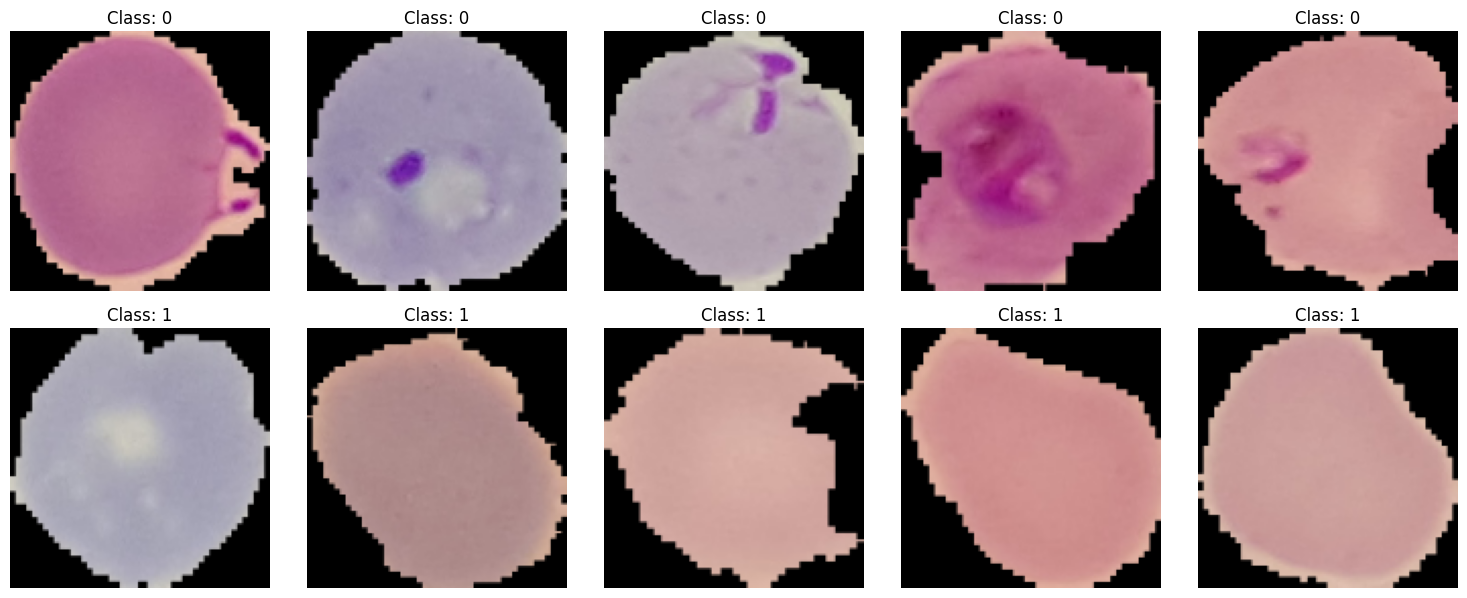

In [5]:
def display_class_images(dataset, num_classes=5, images_per_class=5):
    class_images = {i: [] for i in range(num_classes)}
    class_labels = {i: [] for i in range(num_classes)}
    
   
    for images, labels in dataset.take(1):
        images, labels = images.numpy(), labels.numpy()
        
        
        if labels.ndim > 1 and labels.shape[1] > 1:
            labels = tf.argmax(labels, axis=1).numpy()
        
        
        for img, label in zip(images, labels):
            if len(class_images[label]) < images_per_class:
                class_images[label].append(img)
                class_labels[label].append(label)
    
   
    plt.figure(figsize=(15, 15))
    
    for i in range(num_classes):
        for j in range(images_per_class):
            if j < len(class_images[i]):
                plt.subplot(num_classes, images_per_class, i * images_per_class + j + 1)
                plt.imshow(class_images[i][j].astype("uint8"))
                plt.title(f"Class: {class_labels[i][j]}")
                plt.axis("off")
    
    plt.tight_layout()
    plt.show()


display_class_images(train_ds, num_classes=5, images_per_class=5)

# Preprocess Data

In [6]:
normalization_layer = tf.keras.layers.Rescaling(1/255)

def preprocess_dataset(dataset):
    dataset = dataset.map(lambda x, y: (normalization_layer(x), y))
    dataset = dataset.cache()  
    dataset = dataset.shuffle(buffer_size=1000)  
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)  
    return dataset

train_ds = preprocess_dataset(train_ds)
val_ds = preprocess_dataset(val_ds)

# Build Model

In [7]:
def build_model(hp):
    model = Sequential()
    model.add(MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3)))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    
    num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
    for i in range(num_layers):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32), activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(2, activation='softmax'))
    
    
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
        )
    elif optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
        )
    else:  
        optimizer = tf.keras.optimizers.RMSprop(
            learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
        )
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [8]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=2,
    directory='keras_tuner_dii',
    project_name='malaria_detec'
)


tuner.search(train_ds, epochs=3, validation_data=val_ds, callbacks=[EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)])

Trial 3 Complete [00h 05m 58s]
val_accuracy: 0.9610778391361237

Best val_accuracy So Far: 0.9618943929672241
Total elapsed time: 00h 16m 58s


# Best Hyperparameters

In [9]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for key in best_hyperparameters.values:
    print(f"{key}: {best_hyperparameters[key]}")

Best Hyperparameters:
dropout_rate: 0.2
num_layers: 3
units_0: 32
dropout_0: 0.4
optimizer: sgd
learning_rate: 0.0016172321063289091
units_1: 32
dropout_1: 0.2
units_2: 32
dropout_2: 0.2


# Final model

In [10]:
best_model = build_model(best_hyperparameters)


history = best_model.fit(
    train_ds,
    initial_epoch=3,
    epochs=10, 
    validation_data=val_ds,
    callbacks=[EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)]
)


test_loss, test_accuracy = best_model.evaluate(val_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 4/10
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 71s 34ms/step - accuracy: 0.7767 - loss: 0.4447 - val_accuracy: 0.8300 - val_loss: 0.5128
Epoch 5/10
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.9395 - loss: 0.1808 - val_accuracy: 0.9550 - val_loss: 0.1210
Epoch 6/10
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.9509 - loss: 0.1404 - val_accuracy: 0.9594 - val_loss: 0.1128
Epoch 7/10
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.9562 - loss: 0.1184 - val_accuracy: 0.9615 - val_loss: 0.1130
Epoch 8/10
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.9664 - loss: 0.0957 - val_accuracy: 0.9652 - val_loss: 0.1111
Epoch 9/10
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.9735 - loss: 0.0769 - val_accuracy: 0.9652 - val_loss: 0.1103
Epoch 10/10
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.9764 - loss: 0.0637 - val_accuracy: 0.9657 - val_loss: 0.1425
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9675 - loss: 0.0998


# History Plot¶

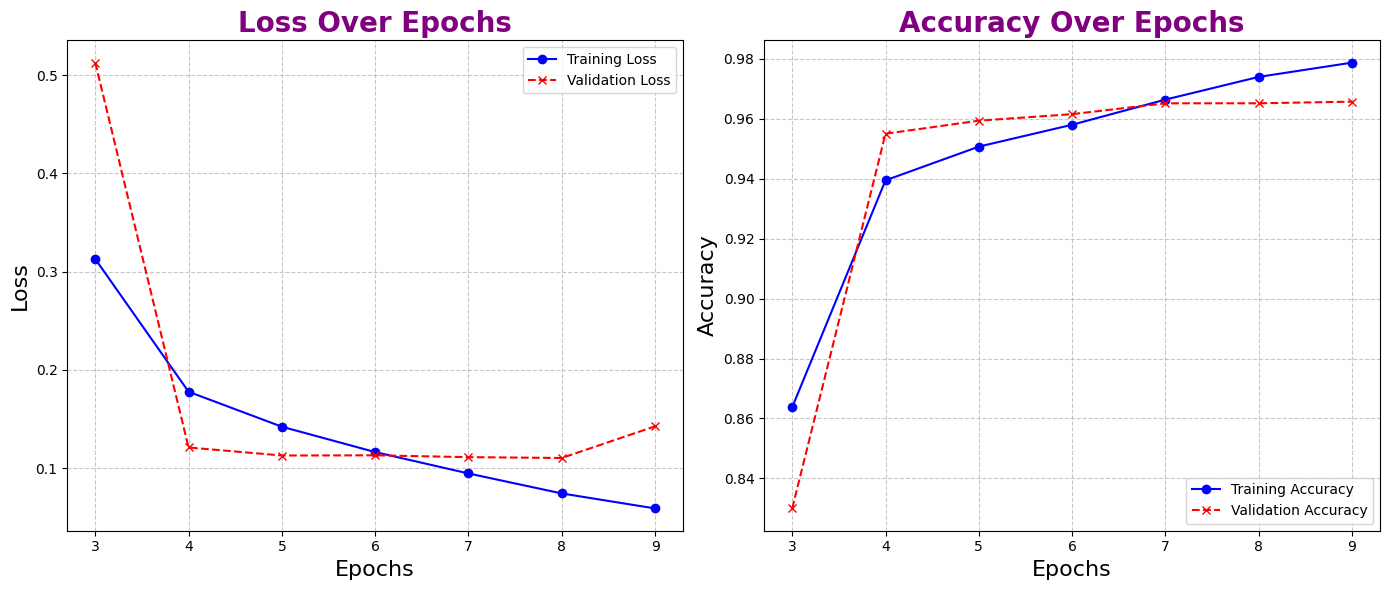

In [11]:
def plot_metrics(history):
    
    epochs = history.epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
   
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, color='blue', linestyle='-', marker='o', label='Training Loss')
    plt.plot(epochs, val_loss, color='red', linestyle='--', marker='x', label='Validation Loss')
    plt.title('Loss Over Epochs', fontsize=20, fontweight='bold', color='purple')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)
    
  
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, color='blue', linestyle='-', marker='o', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, color='red', linestyle='--', marker='x', label='Validation Accuracy')
    plt.title('Accuracy Over Epochs', fontsize=20, fontweight='bold', color='purple')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.7)
    
   
    plt.tight_layout()
    plt.show()


plot_metrics(history)